In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from PIL import Image
import scipy
from scipy import misc
import cv2
import matplotlib.animation as animation
%matplotlib inline

The grid2grid function takes the calculated coordinate system and returns the transformed x,y

In [2]:
def grid2grid(x,y,x_dis, y_dis):
    return (int(np.floor(x+x_dis/100.)), int(np.floor(y+y_dis/100.))) #distance divided by 100m per pixel

Random generated velocity and image to test whether this algorithm works, constant intensity

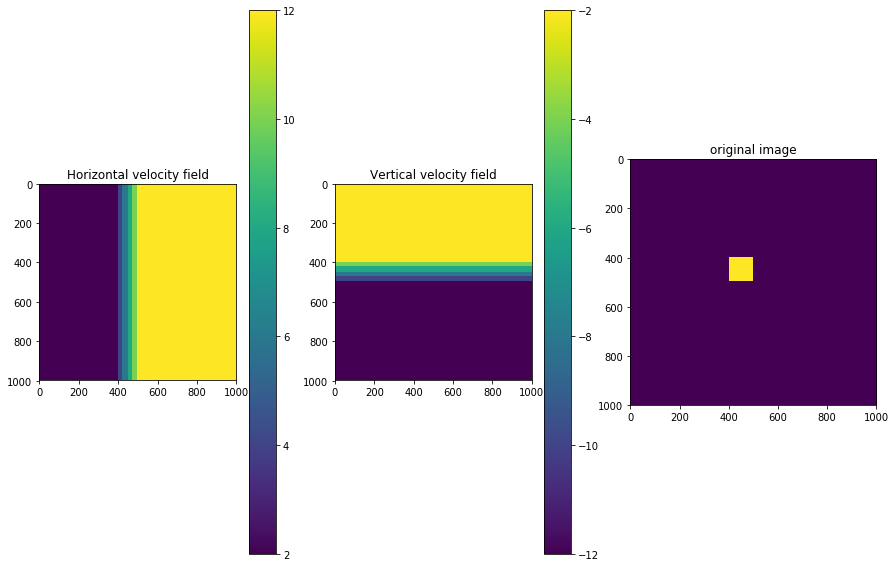

In [59]:
V = np.zeros((1000,1000,2))
V[:,:400,0]=2
V[:,400:420,0] = 4
V[:,420:450,0] = 6
V[:,450:470,0] = 8
V[:,470:500,0] = 10
V[:,500:,0] = 12

V[:400,:,1] = -2
V[400:420,:,1] = -4
V[420:450,:,1] = -6
V[450:470,:,1] = -8
V[470:500,:,1] = -10
V[500:,:,1] = -12

curr_img = np.zeros((1000,1000))
curr_img[400:500, 400:500] = 10

fig =plt.figure(figsize=(15,10))
fig.add_subplot(131)
plt.imshow(V[:,:,0])
plt.colorbar()
plt.title("Horizontal velocity field");
fig.add_subplot(132)
plt.imshow(V[:,:,1])
plt.colorbar()
plt.title("Vertical velocity field");
fig.add_subplot(133)
plt.imshow(curr_img)
plt.title("original image");

## Numerical Solutions

### Advection
To solve for the first order advection equation, numerical solutions are taken to adaptively calculate the image for the next time step and then transform the grid into predicted images
$$
    I_{x,y}^{t+1} = I_{x,y}^t-\frac{U*dt}{dx}(I_{x,y}^t-I_{x-dx,y}^{t})- \frac{V*dt}{dy}(I_{x,y}^t-I_{x,{y-dy}}^t)
$$

In [119]:
def ADE_solver(curr_img, V , dt, nt):
    U = V[:,:,0]
    V = V[:,:,1]
    pred=[]
    In = curr_img.copy()
    for t in range(0,dt*nt, dt):
        pred_img = np.zeros((1000,1000))
        In[1:,1:] = curr_img[1:,1:] -U[1:,1:]*dt/100.*(curr_img[1:,1:]-curr_img[1:,0:-1]) -\
                    V[1:,1:]*dt/100.*(curr_img[1:,1:]-curr_img[0:-1,1:])
        x,y = np.where(In!=0)
        for (m,n) in zip(x,y):
            d_x, d_y = U[m,n]*dt, V[m,n]*dt
#            new_mat = diffusion(nx,ny,dt,D)*In[m,n]
            (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
            if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
                pred_img[trans_i, trans_j] = In[m,n]
        curr_img=pred_img
        if t%60==0:
#            x,y = np.where(In!=0)
#            for (m,n) in zip(x,y):
#                d_x, d_y = U[m,n]*t, V[m,n]*t
#                new_mat = diffusion(nx,ny,dt,D)*In[m,n]
#                (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
#                if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                    pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-{t}.png', pred_img)
            print(int(t/60),' mins processed')
            pred.append(pred_img)
    return pred


pred = ADE_solver(curr_img,V,5,360)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


0  mins processed
1  mins processed
2  mins processed
3  mins processed
4  mins processed
5  mins processed
6  mins processed
7  mins processed
8  mins processed
9  mins processed
10  mins processed
11  mins processed
12  mins processed
13  mins processed
14  mins processed
15  mins processed
16  mins processed
17  mins processed
18  mins processed
19  mins processed
20  mins processed
21  mins processed
22  mins processed
23  mins processed
24  mins processed
25  mins processed
26  mins processed
27  mins processed
28  mins processed
29  mins processed


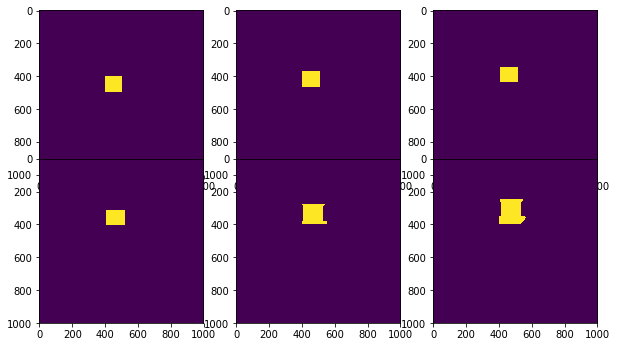

In [112]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(231)
plt.imshow(pred[0])
fig.add_subplot(232)
plt.imshow(pred[1])
fig.add_subplot(233)
plt.imshow(pred[2])
fig.add_subplot(131)
plt.imshow(pred[3])
fig.add_subplot(132)
plt.imshow(pred[4])
fig.add_subplot(133)
plt.imshow(pred[5])

### Advection + Diffusion

The first oder Advection equation is not able to fill the gaps e.g. some pixels run faster than others, then gaps will be created. The other way is to add second order term - diffusion. One simple way of taking this sparse distribution into account is by Gaussian filter. In each pixel, the additional Gaussian diffusion term will be added. This should be calibrated because it can not be realistic high as it will cause merge, and if it is low, it would not cover the gaps. Of course, it depends on velocity field.

$$
T(x,y,t)=\frac{1}{4\pi*dt}exp(\frac{-(x-x_0)^2}{4Dt_0}+\frac{-(y-y_0)^2}{4Dt_0})
$$

$$
    I_{x,y}^{t+1} = I_{x,y}^t-\frac{U*dt}{dx}(I_{x,y}^t-I_{x-dx,y}^{t})- \frac{V*dt}{dy}(I_{x,y}^t-I_{x,{y-dy}}^t)+\frac{D*dt}{dx^2}(I_{x+1,y}+I_{x-1,y}-2I_{x,y})+\frac{D*dt}{dy^2}(I_{x,y+1}+I_{x,y-1}-2I_{x,y})
$$

Stability Analysis:


In [61]:
from numba import jit
@jit(nopython=True)
def diffusion(nx,ny,dt,D):
    new_matrix = np.zeros((nx,ny), dtype=np.float64)
    X = np.arange(-nx*100,nx*100,nx+1)
    Y = np.arange(-ny*100,ny*100,ny+1)
    for i in range(nx):
        for j in range(ny):
            new_matrix[i,j] = np.exp(-X[i]**2/4/D/dt-Y[j]**2/4/D/dt)/1/dt/np.pi
    return new_matrix

In [109]:
def ADE_solver(curr_img, V ,D, nx, ny, dt, nt):
    U = V[:,:,0]
    V = V[:,:,1]
    pred=[]
    In = curr_img.copy()
    for t in range(0,dt*nt, dt):
        pred_img = np.zeros((1000,1000))
        In[2:,2:] = curr_img[2:,2:] -U[2:,2:]*dt/100./2*(curr_img[2:,2:]-curr_img[2:,0:-2]) -\
                    V[2:,2:]*dt/100./2*(curr_img[2:,2:]-curr_img[0:-2,2:])+D*dt/100**2*(curr_img[2:,2:]+curr_img[2:,:-2]-
                                                                                      2*curr_img[2:,1:-1])+\
                    D*dt/100**2*(curr_img[2:,2:]+curr_img[:-2,2:]-curr_img[1:-1,2:])
        x,y = np.where(In!=0)
        for (m,n) in zip(x,y):
            d_x, d_y = U[m,n]*dt, V[m,n]*dt
#            new_mat = diffusion(nx,ny,dt,D)*In[m,n]
            (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
            if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
                pred_img[trans_i, trans_j] = In[m,n]
        curr_img=pred_img
        if t%60==0:
#            x,y = np.where(In!=0)
#            for (m,n) in zip(x,y):
#                d_x, d_y = U[m,n]*t, V[m,n]*t
#                new_mat = diffusion(nx,ny,dt,D)*In[m,n]
#                (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
#                if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                    pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-diff-{t}.png', pred_img)
            print(int(t/60),' mins processed')
            pred.append(pred_img)
    return pred


pred = ADE_solver(curr_img,V,0,100,100,5,360)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


0  mins processed
1  mins processed
2  mins processed
3  mins processed
4  mins processed
5  mins processed
6  mins processed


KeyboardInterrupt: 

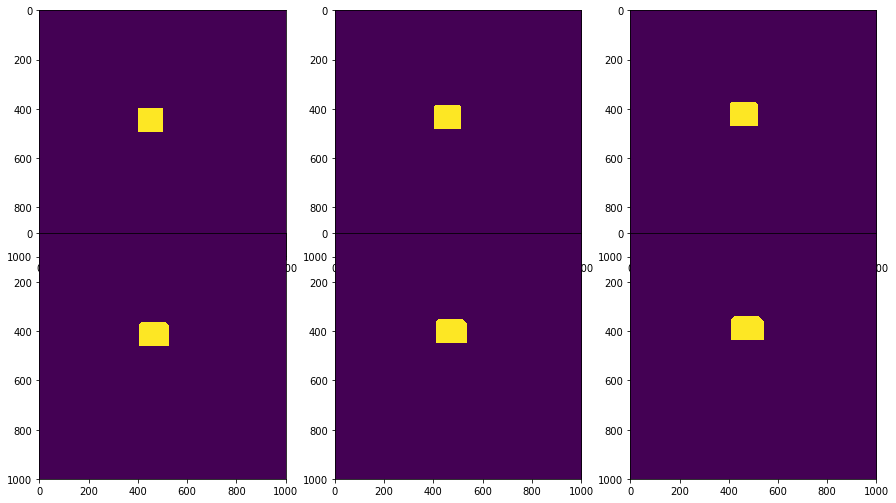

In [107]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(231)
plt.imshow(pred[0])
fig.add_subplot(232)
plt.imshow(pred[1])
fig.add_subplot(233)
plt.imshow(pred[2])
fig.add_subplot(131)
plt.imshow(pred[3])
fig.add_subplot(132)
plt.imshow(pred[4])
fig.add_subplot(133)
plt.imshow(pred[5])

### Issues after numerical implementation

**The issues remained for sovling 2-D advection diffusion equation are:**


1. the discontinuity (may be due to the incorrectness of the codes), and the stability needs to be checked.


2. Haven't tested the real world cloud images

## Analytical Solution

If the dispersion term can be simulated as Gaussian distribution, the analytical solution of the particle movement can be derived from that. The equations described as below:

$$
I(x,y,t) = \frac{I_{total}}{\sqrt{4\pi Dt}}exp(-\frac{(x-ut)^2+(y-vt)^2}{4Dt})
$$

In this way, the numerical diffusion can be mitigated

In [31]:
from numba import jit
@jit(nopython=True)
def fast_iter(m,n,D,dt, grid=2):
    X = np.arange(-100*grid,100*grid+100,100)
    Y = np.arange(-100*grid,100*grid+100,100)
    unit_I = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            unit_I[i,j] = 1/(4*np.pi*D*dt)**0.5*np.exp(-(X[i]**2+Y[j]**2)/4/D/dt)
    unit_I = (unit_I-unit_I.min())/(unit_I.max()-unit_I.min())
    return unit_I


In [32]:
def ANA(curr_img, V, D,t,k=5):
    U = V[:,:,0]
    V = V[:,:,1]
    x,y = np.where(curr_img!=0)
#    print(x,y)
    next_img = np.zeros((1000,1000))
    for m,n in zip(x,y):
        d_x = U[m,n]*t
        d_y = V[m,n]*t
#        print(d_x, d_y)
        new_mat = fast_iter(m,n,D,dt=60)*curr_img[m,n]
        (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
        if 0<=trans_i+int(k/2)+1<999 and 0<=trans_j+int(k/2)+1<=999:
            try:
                next_img[trans_i-int(k/2):trans_i+int(k/2)+1, trans_j-int(k/2):trans_j+int(k/2)+1] += new_mat
            except ValueError:
                print(trans_i, trans_j, trans_i-int(k/2),trans_i+int(k/2)+1, trans_j-int(k/2),trans_j+int(k/2)+1)
#        print(next_img[trans_i-int(k/2):trans_i+int(k/2)+1, trans_j-int(k/2):trans_j+int(k/2)+1].shape)
        
#    print(trans_i, trans_j)
    return next_img


In [40]:
def execute(curr_img,V):
    pred= []
    for t in range(60,1800,60):
        pred_img = ANA(curr_img, V, 100, 60)
        curr_img = pred_img.copy()
        if t%60==0:
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-ana-{t}.png', pred_img)
            print(int(t/60),' mins processed')
            pred.append(pred_img)
    return pred
pred=execute(curr_img, V)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


1  mins processed
2  mins processed
3  mins processed
4  mins processed
5  mins processed
6  mins processed
7  mins processed
8  mins processed
9  mins processed
10  mins processed
11  mins processed
12  mins processed
13  mins processed
14  mins processed
15  mins processed
16  mins processed
17  mins processed
18  mins processed
19  mins processed
20  mins processed
21  mins processed
22  mins processed
23  mins processed
24  mins processed
25  mins processed
26  mins processed
27  mins processed
28  mins processed
29  mins processed


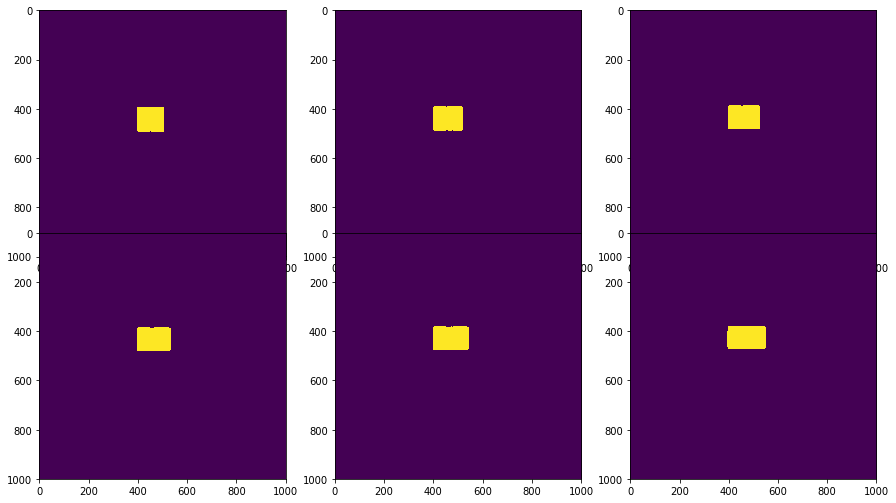

In [41]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(231)
plt.imshow(pred[0])
fig.add_subplot(232)
plt.imshow(pred[1])
fig.add_subplot(233)
plt.imshow(pred[2])
fig.add_subplot(131)
plt.imshow(pred[3])
fig.add_subplot(132)
plt.imshow(pred[4])
fig.add_subplot(133)
plt.imshow(pred[5])

### Issues of analytical solution:

**numerical discontinuity can be mitigated a lot. But still some problems stay:**


1. The diffusion coefficient needs to be calibrated


2. edges are not smooth enough (maybe some filters can adjust that)


3. How velocity field affects - the sort of reasonable range of velocity?


4. How intensity distribution affects the algorithm?

# Analytical Model for Improving Radar Nowcast

#### Parameter Description

**Functions:**

    1.fast_iter(m,n,D,dt,grid=2)
    --------------
    Args:
    m,n: the grid where rainfall intensity exists
    D: diffusion coefficient
    dt: time step
    grid: the matrix to generate Gaussian matrix. Square matrix
    --------------
    Return:
    mat: generated Gaussian matrix

    2. ANA(curr_img, V, D, t, k=5)
    --------------
    Args:
    curr_img: current radar image: (1000x1000)
    V: velocity field. (1000,1000,2), U=V[:,:,0]; V=V[:,:,1]
    D: diffusion coefficient
    t: time from the reference time
    k: corresponds with grid in <fast_iter>, square matrix in the predicted image to be replaced with
    --------------
    Returns:
    next_img: predicted image at next time stamp

    3. grid2grid(x,y,x_dis,y_dis)
    --------------
    Args:
    x,y: the grid(pixel) where rainfall exist
    x_dis, y_dis: the distance of that particular pixel moves
    --------------
    Returns:
    new translated x,y grid 
   
    4. execute: execution of the algorithm


In [60]:
def grid2grid(x,y,x_dis, y_dis):
    return (int(np.floor(x+x_dis/100.)), int(np.floor(y+y_dis/100.))) #distance divided by 100m per pixel

In [3]:
from numba import jit
@jit(nopython=True)
def fast_iter(m,n,D,dt, grid=2):
    X = np.arange(-100*grid,100*grid+100,100)
    Y = np.arange(-100*grid,100*grid+100,100)
    unit_I = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            unit_I[i,j] = 1/(4*np.pi*D*dt)**0.5*np.exp(-(X[i]**2+Y[j]**2)/4/D/dt)
    unit_I = (unit_I-unit_I.min())/(unit_I.max()-unit_I.min())
    return unit_I

In [4]:
def ANA(curr_img, V, D,t,k=5):
    U = V[:,:,0]
    V = V[:,:,1]
    x,y = np.where(curr_img!=0)
#    print(x,y)
    next_img = np.zeros((1000,1000))
    for m,n in zip(x,y):
        d_x = U[m,n]*t
        d_y = V[m,n]*t
#        print(d_x, d_y)
        new_mat = fast_iter(m,n,D,dt=60)*curr_img[m,n]
        (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
        if 1<=trans_i+int(k/2)+1<999 and 1<=trans_j+int(k/2)+1<=999:
            try:
                next_img[trans_i-int(k/2):trans_i+int(k/2)+1, trans_j-int(k/2):trans_j+int(k/2)+1] += new_mat
            except ValueError:
                print(trans_i, trans_j, trans_i-int(k/2),trans_i+int(k/2)+1, trans_j-int(k/2),trans_j+int(k/2)+1)
#        print(next_img[trans_i-int(k/2):trans_i+int(k/2)+1, trans_j-int(k/2):trans_j+int(k/2)+1].shape)
        
#    print(trans_i, trans_j)
    return next_img


In [84]:
def execute(curr_img,V):
    pred= []
    for t in range(0,300,60):
        pred_img = ANA(curr_img, V, 100, 60)
        curr_img = pred_img.copy()
        if t%60==0:
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
#             scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-ana-{t}.png', pred_img)
            print(int(t/60),' mins processed')

            img = plt.imshow(pred_img, animated=True)
            pred.append([img])
    return pred


### Experiment 1: real radar images + Uniform velocity

Parameter description:

    D=100
    dt=60
    V=5 uniform

In [93]:
os.chdir('D:\\Radar Projects\\lizhi\\for LiZhi\\WindField')
curr_img = np.matrix(Image.open('test_file.tif'))
V=np.ones((1000,1000,2))*5

In [123]:
from matplotlib import animation
from IPython.display import HTML
def make_animation(t_max, curr_img,V,D, verbose=False):
    fig = plt.figure();
    pred= []
    for t in range(0,t_max,60):
        pred_img = ANA(curr_img, V, D, 60)
        curr_img = pred_img.copy()
        if t%60==0:
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            if verbose:
                print(int(t/60),' mins processed')
            img = plt.imshow(pred_img, animated=True)
            text = plt.text(400,-10,f'{int(t/60)} min',color='black')
            pred.append([img, text])
    ani = animation.ArtistAnimation(fig, pred, interval=500, blit=True,
                                repeat_delay=1000)
    return ani

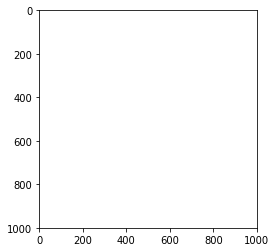

In [117]:
ani = make_animation(1860, curr_img,V,100)

In [118]:
from IPython.display import HTML
HTML(ani.to_jshtml())

#### Summary

1. Eventually, all go to blends because of diffusion


### Experiment 2: real radar images + velocity gradient

Parameter Description:

    D=100
    dt=60
    V: the velocity ranges from 0 to 18 with interval of 2
    

In [119]:
V = np.zeros((1000,1000,2))
V[:,100:200,0]=2
V[:,200:300,0]=4
V[:,300:400,0]=6
V[:,400:500,0]=8
V[:,500:600,0]=10
V[:,600:700,0]=12
V[:,700:800,0]=14
V[:,800:900,0]=16
V[:,900:1000,1]=18
V[100:200,:,1]=2
V[200:300,:,1]=4
V[300:400,:,1]=6
V[400:500,:,1]=8
V[500:600,:,1]=10
V[600:700,:,1]=12
V[700:800,:,1]=14
V[800:900,:,1]=16
V[900:1000,:,1]=18

1 641 -1 4 639 644
1 642 -1 4 640 645
1 643 -1 4 641 646
1 644 -1 4 642 647
1 645 -1 4 643 648
1 646 -1 4 644 649
1 647 -1 4 645 650
1 648 -1 4 646 651
1 649 -1 4 647 652
1 650 -1 4 648 653
1 651 -1 4 649 654
1 652 -1 4 650 655
1 653 -1 4 651 656
1 654 -1 4 652 657
1 655 -1 4 653 658
1 656 -1 4 654 659
1 657 -1 4 655 660
1 658 -1 4 656 661
1 659 -1 4 657 662
1 660 -1 4 658 663
1 661 -1 4 659 664
0 643 -2 3 641 646
0 644 -2 3 642 647
0 645 -2 3 643 648
0 646 -2 3 644 649
0 647 -2 3 645 650
0 648 -2 3 646 651
0 649 -2 3 647 652
0 650 -2 3 648 653
0 651 -2 3 649 654
0 652 -2 3 650 655
0 653 -2 3 651 656
0 654 -2 3 652 657
0 655 -2 3 653 658
0 656 -2 3 654 659
0 657 -2 3 655 660
0 658 -2 3 656 661
0 659 -2 3 657 662
0 660 -2 3 658 663
0 661 -2 3 659 664
0 662 -2 3 660 665
0 663 -2 3 661 666
0 664 -2 3 662 667
0 665 -2 3 663 668
0 666 -2 3 664 669
0 667 -2 3 665 670
0 668 -2 3 666 671
0 669 -2 3 667 672
0 670 -2 3 668 673
0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
1 639 -1 4 6

0 659 -2 3 657 662
0 660 -2 3 658 663
0 661 -2 3 659 664
0 662 -2 3 660 665
0 663 -2 3 661 666
0 664 -2 3 662 667
0 665 -2 3 663 668
0 666 -2 3 664 669
0 667 -2 3 665 670
0 668 -2 3 666 671
0 669 -2 3 667 672
0 670 -2 3 668 673
0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
0 674 -2 3 672 677
0 675 -2 3 673 678
0 676 -2 3 674 679
0 677 -2 3 675 680
0 678 -2 3 676 681
0 679 -2 3 677 682
0 680 -2 3 678 683
0 681 -2 3 679 684
0 682 -2 3 680 685
0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 7

0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
0 674 -2 3 672 677
0 675 -2 3 673 678
0 676 -2 3 674 679
0 677 -2 3 675 680
0 678 -2 3 676 681
0 679 -2 3 677 682
0 680 -2 3 678 683
0 681 -2 3 679 684
0 682 -2 3 680 685
0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 7

0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 722 727
0 725 -2 3 723 728
0 726 -2 3 724 729
0 727 -2 3 725 730
0 728 -2 3 726 731
0 729 -2 3 727 732
0 730 -2 3 728 733
0 731 -2 3 729 734
0 732 -2 3 730 735
0 733 -2 3 731 736
0 734 -2 3 732 737
0 735 -2 3 733 738
0 736 -2 3 7

0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 722 727
0 725 -2 3 723 728
0 726 -2 3 724 729
0 727 -2 3 725 730
0 728 -2 3 726 731
0 729 -2 3 727 732
0 730 -2 3 728 733
0 731 -2 3 729 734
0 732 -2 3 730 735
0 733 -2 3 731 736
0 734 -2 3 732 737
0 735 -2 3 733 738
0 736 -2 3 734 739
0 737 -2 3 735 740
0 738 -2 3 736 741
0 739 -2 3 737 742
0 740 -2 3 738 743
0 741 -2 3 739 744
0 742 -2 3 740 745
0 743 -2 3 741 746
0 744 -2 3 7

1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 833 838
1 836 -1 4 834 839
1 837 -1 4 835 840
1 838 -1 4 836 841
1 839 -1 4 837 842
1 840 -1 4 838 843
1 841 -1 4 839 844
1 842 -1 4 840 845
1 843 -1 4 841 846
1 844 -1 4 842 847
1 845 -1 4 843 848
1 846 -1 4 844 849
1 847 -1 4 845 850
1 848 -1 4 846 851
1 849 -1 4 847 852
1 850 -1 4 848 853
1 851 -1 4 849 854
1 852 -1 4 850 855
1 853 -1 4 851 856
1 854 -1 4 852 857
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 7

1 284 -1 4 282 287
1 285 -1 4 283 288
1 286 -1 4 284 289
1 287 -1 4 285 290
1 288 -1 4 286 291
1 289 -1 4 287 292
1 290 -1 4 288 293
1 291 -1 4 289 294
1 292 -1 4 290 295
1 293 -1 4 291 296
1 294 -1 4 292 297
1 295 -1 4 293 298
1 296 -1 4 294 299
1 297 -1 4 295 300
1 298 -1 4 296 301
1 703 -1 4 701 706
1 704 -1 4 702 707
1 705 -1 4 703 708
1 706 -1 4 704 709
1 708 -1 4 706 711
1 709 -1 4 707 712
1 710 -1 4 708 713
1 711 -1 4 709 714
1 712 -1 4 710 715
1 713 -1 4 711 716
1 714 -1 4 712 717
1 715 -1 4 713 718
1 716 -1 4 714 719
1 717 -1 4 715 720
1 718 -1 4 716 721
1 719 -1 4 717 722
1 720 -1 4 718 723
1 721 -1 4 719 724
1 722 -1 4 720 725
1 723 -1 4 721 726
1 724 -1 4 722 727
1 725 -1 4 723 728
1 726 -1 4 724 729
1 727 -1 4 725 730
1 728 -1 4 726 731
1 729 -1 4 727 732
1 730 -1 4 728 733
1 731 -1 4 729 734
1 732 -1 4 730 735
1 733 -1 4 731 736
1 734 -1 4 732 737
1 735 -1 4 733 738
1 736 -1 4 734 739
1 737 -1 4 735 740
1 738 -1 4 736 741
1 739 -1 4 737 742
1 740 -1 4 738 743
1 741 -1 4 7

1 240 -1 4 238 243
1 241 -1 4 239 244
1 242 -1 4 240 245
1 243 -1 4 241 246
1 244 -1 4 242 247
1 245 -1 4 243 248
1 246 -1 4 244 249
1 247 -1 4 245 250
1 248 -1 4 246 251
1 249 -1 4 247 252
1 250 -1 4 248 253
1 251 -1 4 249 254
1 252 -1 4 250 255
1 253 -1 4 251 256
1 254 -1 4 252 257
1 255 -1 4 253 258
1 256 -1 4 254 259
1 257 -1 4 255 260
1 258 -1 4 256 261
1 259 -1 4 257 262
1 260 -1 4 258 263
1 261 -1 4 259 264
1 262 -1 4 260 265
1 263 -1 4 261 266
1 264 -1 4 262 267
1 265 -1 4 263 268
1 266 -1 4 264 269
1 267 -1 4 265 270
1 268 -1 4 266 271
1 269 -1 4 267 272
1 270 -1 4 268 273
1 271 -1 4 269 274
1 272 -1 4 270 275
1 273 -1 4 271 276
1 274 -1 4 272 277
1 275 -1 4 273 278
1 276 -1 4 274 279
1 277 -1 4 275 280
1 278 -1 4 276 281
1 279 -1 4 277 282
1 280 -1 4 278 283
1 281 -1 4 279 284
1 282 -1 4 280 285
1 283 -1 4 281 286
1 284 -1 4 282 287
1 285 -1 4 283 288
1 286 -1 4 284 289
1 287 -1 4 285 290
1 288 -1 4 286 291
1 289 -1 4 287 292
1 290 -1 4 288 293
1 291 -1 4 289 294
1 292 -1 4 2

1 202 -1 4 200 205
1 203 -1 4 201 206
1 204 -1 4 202 207
1 205 -1 4 203 208
1 206 -1 4 204 209
1 207 -1 4 205 210
1 208 -1 4 206 211
1 209 -1 4 207 212
1 210 -1 4 208 213
1 211 -1 4 209 214
1 212 -1 4 210 215
1 213 -1 4 211 216
1 214 -1 4 212 217
1 215 -1 4 213 218
1 216 -1 4 214 219
1 217 -1 4 215 220
1 218 -1 4 216 221
1 219 -1 4 217 222
1 220 -1 4 218 223
1 221 -1 4 219 224
1 222 -1 4 220 225
1 223 -1 4 221 226
1 224 -1 4 222 227
1 225 -1 4 223 228
1 226 -1 4 224 229
1 227 -1 4 225 230
1 228 -1 4 226 231
1 229 -1 4 227 232
1 230 -1 4 228 233
1 231 -1 4 229 234
1 232 -1 4 230 235
1 233 -1 4 231 236
1 234 -1 4 232 237
1 235 -1 4 233 238
1 236 -1 4 234 239
1 237 -1 4 235 240
1 238 -1 4 236 241
1 239 -1 4 237 242
1 240 -1 4 238 243
1 241 -1 4 239 244
1 242 -1 4 240 245
1 243 -1 4 241 246
1 244 -1 4 242 247
1 245 -1 4 243 248
1 246 -1 4 244 249
1 247 -1 4 245 250
1 248 -1 4 246 251
1 249 -1 4 247 252
1 250 -1 4 248 253
1 251 -1 4 249 254
1 252 -1 4 250 255
1 253 -1 4 251 256
1 254 -1 4 2

0 847 -2 3 845 850
0 848 -2 3 846 851
0 849 -2 3 847 852
0 850 -2 3 848 853
0 851 -2 3 849 854
0 852 -2 3 850 855
0 853 -2 3 851 856
0 854 -2 3 852 857
0 855 -2 3 853 858
0 856 -2 3 854 859
0 857 -2 3 855 860
0 858 -2 3 856 861
0 859 -2 3 857 862
0 860 -2 3 858 863
0 861 -2 3 859 864
0 862 -2 3 860 865
0 863 -2 3 861 866
0 864 -2 3 862 867
0 865 -2 3 863 868
0 866 -2 3 864 869
0 867 -2 3 865 870
0 868 -2 3 866 871
0 869 -2 3 867 872
0 870 -2 3 868 873
0 871 -2 3 869 874
0 872 -2 3 870 875
0 873 -2 3 871 876
0 874 -2 3 872 877
0 875 -2 3 873 878
0 876 -2 3 874 879
0 877 -2 3 875 880
0 878 -2 3 876 881
0 879 -2 3 877 882
0 880 -2 3 878 883
0 881 -2 3 879 884
0 882 -2 3 880 885
0 883 -2 3 881 886
0 884 -2 3 882 887
0 885 -2 3 883 888
0 886 -2 3 884 889
0 887 -2 3 885 890
0 888 -2 3 886 891
0 889 -2 3 887 892
0 890 -2 3 888 893
0 891 -2 3 889 894
0 892 -2 3 890 895
0 893 -2 3 891 896
0 894 -2 3 892 897
0 895 -2 3 893 898
0 896 -2 3 894 899
0 897 -2 3 895 900
0 898 -2 3 896 901
0 899 -2 3 8

1 880 -1 4 878 883
1 881 -1 4 879 884
1 882 -1 4 880 885
1 883 -1 4 881 886
1 884 -1 4 882 887
1 885 -1 4 883 888
1 886 -1 4 884 889
1 887 -1 4 885 890
1 888 -1 4 886 891
1 889 -1 4 887 892
1 890 -1 4 888 893
1 891 -1 4 889 894
1 892 -1 4 890 895
1 893 -1 4 891 896
1 894 -1 4 892 897
1 895 -1 4 893 898
1 896 -1 4 894 899
1 897 -1 4 895 900
1 898 -1 4 896 901
1 899 -1 4 897 902
1 900 -1 4 898 903
1 901 -1 4 899 904
1 902 -1 4 900 905
1 903 -1 4 901 906
1 904 -1 4 902 907
1 905 -1 4 903 908
1 906 -1 4 904 909
1 907 -1 4 905 910
1 908 -1 4 906 911
0 194 -2 3 192 197
0 195 -2 3 193 198
0 196 -2 3 194 199
0 197 -2 3 195 200
0 198 -2 3 196 201
0 199 -2 3 197 202
0 200 -2 3 198 203
0 202 -2 3 200 205
0 203 -2 3 201 206
0 204 -2 3 202 207
0 205 -2 3 203 208
0 206 -2 3 204 209
0 207 -2 3 205 210
0 208 -2 3 206 211
0 209 -2 3 207 212
0 210 -2 3 208 213
0 211 -2 3 209 214
0 212 -2 3 210 215
0 213 -2 3 211 216
0 214 -2 3 212 217
0 215 -2 3 213 218
0 216 -2 3 214 219
0 217 -2 3 215 220
0 218 -2 3 2

1 329 -1 4 327 332
1 330 -1 4 328 333
1 331 -1 4 329 334
1 332 -1 4 330 335
1 443 -1 4 441 446
1 444 -1 4 442 447
1 445 -1 4 443 448
1 446 -1 4 444 449
1 447 -1 4 445 450
1 448 -1 4 446 451
1 449 -1 4 447 452
1 450 -1 4 448 453
1 451 -1 4 449 454
1 452 -1 4 450 455
1 453 -1 4 451 456
1 454 -1 4 452 457
1 455 -1 4 453 458
1 456 -1 4 454 459
1 457 -1 4 455 460
1 458 -1 4 456 461
1 459 -1 4 457 462
1 460 -1 4 458 463
1 461 -1 4 459 464
1 462 -1 4 460 465
1 463 -1 4 461 466
1 464 -1 4 462 467
1 465 -1 4 463 468
1 466 -1 4 464 469
1 467 -1 4 465 470
1 468 -1 4 466 471
1 469 -1 4 467 472
1 470 -1 4 468 473
1 471 -1 4 469 474
1 472 -1 4 470 475
1 473 -1 4 471 476
1 474 -1 4 472 477
1 475 -1 4 473 478
1 476 -1 4 474 479
1 477 -1 4 475 480
1 478 -1 4 476 481
1 479 -1 4 477 482
1 480 -1 4 478 483
1 481 -1 4 479 484
1 482 -1 4 480 485
1 483 -1 4 481 486
1 484 -1 4 482 487
1 485 -1 4 483 488
1 486 -1 4 484 489
1 487 -1 4 485 490
1 488 -1 4 486 491
1 489 -1 4 487 492
1 490 -1 4 488 493
1 491 -1 4 4

0 760 -2 3 758 763
0 761 -2 3 759 764
0 762 -2 3 760 765
0 763 -2 3 761 766
0 764 -2 3 762 767
0 765 -2 3 763 768
0 766 -2 3 764 769
0 767 -2 3 765 770
0 768 -2 3 766 771
0 769 -2 3 767 772
0 770 -2 3 768 773
0 771 -2 3 769 774
0 772 -2 3 770 775
0 773 -2 3 771 776
0 774 -2 3 772 777
0 775 -2 3 773 778
0 776 -2 3 774 779
0 777 -2 3 775 780
0 778 -2 3 776 781
0 779 -2 3 777 782
0 780 -2 3 778 783
0 781 -2 3 779 784
0 782 -2 3 780 785
0 783 -2 3 781 786
0 784 -2 3 782 787
0 785 -2 3 783 788
0 786 -2 3 784 789
0 787 -2 3 785 790
0 788 -2 3 786 791
0 789 -2 3 787 792
0 790 -2 3 788 793
0 791 -2 3 789 794
0 792 -2 3 790 795
0 793 -2 3 791 796
0 794 -2 3 792 797
0 795 -2 3 793 798
0 796 -2 3 794 799
0 797 -2 3 795 800
0 798 -2 3 796 801
0 799 -2 3 797 802
0 800 -2 3 798 803
0 801 -2 3 799 804
0 802 -2 3 800 805
0 803 -2 3 801 806
0 804 -2 3 802 807
0 805 -2 3 803 808
0 806 -2 3 804 809
0 807 -2 3 805 810
0 809 -2 3 807 812
0 810 -2 3 808 813
0 811 -2 3 809 814
0 812 -2 3 810 815
0 813 -2 3 8

1 811 -1 4 809 814
1 812 -1 4 810 815
1 813 -1 4 811 816
1 814 -1 4 812 817
1 815 -1 4 813 818
1 816 -1 4 814 819
1 817 -1 4 815 820
1 818 -1 4 816 821
1 819 -1 4 817 822
1 820 -1 4 818 823
1 821 -1 4 819 824
1 822 -1 4 820 825
1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 833 838
1 836 -1 4 834 839
1 837 -1 4 835 840
1 838 -1 4 836 841
1 839 -1 4 837 842
1 840 -1 4 838 843
1 841 -1 4 839 844
1 842 -1 4 840 845
1 843 -1 4 841 846
1 844 -1 4 842 847
1 845 -1 4 843 848
1 846 -1 4 844 849
1 847 -1 4 845 850
1 848 -1 4 846 851
1 849 -1 4 847 852
1 850 -1 4 848 853
1 851 -1 4 849 854
1 852 -1 4 850 855
1 853 -1 4 851 856
1 854 -1 4 852 857
1 855 -1 4 853 858
1 856 -1 4 854 859
1 857 -1 4 855 860
1 858 -1 4 856 861
1 859 -1 4 857 862
1 860 -1 4 858 863
1 861 -1 4 859 864
1 862 -1 4 860 865
1 863 -1 4 8

0 765 -2 3 763 768
0 766 -2 3 764 769
0 767 -2 3 765 770
0 768 -2 3 766 771
0 769 -2 3 767 772
0 770 -2 3 768 773
0 771 -2 3 769 774
0 772 -2 3 770 775
0 773 -2 3 771 776
0 774 -2 3 772 777
0 775 -2 3 773 778
0 776 -2 3 774 779
0 777 -2 3 775 780
0 778 -2 3 776 781
0 779 -2 3 777 782
0 780 -2 3 778 783
0 781 -2 3 779 784
0 782 -2 3 780 785
0 783 -2 3 781 786
0 784 -2 3 782 787
0 785 -2 3 783 788
0 786 -2 3 784 789
0 787 -2 3 785 790
0 788 -2 3 786 791
0 789 -2 3 787 792
0 790 -2 3 788 793
0 791 -2 3 789 794
0 792 -2 3 790 795
0 793 -2 3 791 796
0 794 -2 3 792 797
0 795 -2 3 793 798
0 796 -2 3 794 799
0 797 -2 3 795 800
0 798 -2 3 796 801
0 799 -2 3 797 802
0 800 -2 3 798 803
0 801 -2 3 799 804
0 802 -2 3 800 805
0 803 -2 3 801 806
0 804 -2 3 802 807
0 805 -2 3 803 808
0 806 -2 3 804 809
0 807 -2 3 805 810
0 809 -2 3 807 812
0 810 -2 3 808 813
0 811 -2 3 809 814
0 812 -2 3 810 815
0 813 -2 3 811 816
0 814 -2 3 812 817
0 815 -2 3 813 818
0 816 -2 3 814 819
0 817 -2 3 815 820
0 818 -2 3 8

311 1 309 314 -1 4
312 1 310 315 -1 4
313 1 311 316 -1 4
314 1 312 317 -1 4
315 0 313 318 -2 3
315 1 313 318 -1 4
316 0 314 319 -2 3
316 1 314 319 -1 4
317 0 315 320 -2 3
317 1 315 320 -1 4
318 0 316 321 -2 3
318 1 316 321 -1 4
319 0 317 322 -2 3
319 1 317 322 -1 4
320 0 318 323 -2 3
320 1 318 323 -1 4
321 0 319 324 -2 3
321 1 319 324 -1 4
322 0 320 325 -2 3
322 1 320 325 -1 4
323 0 321 326 -2 3
323 1 321 326 -1 4
324 0 322 327 -2 3
324 1 322 327 -1 4
325 0 323 328 -2 3
325 1 323 328 -1 4
326 0 324 329 -2 3
326 1 324 329 -1 4
327 0 325 330 -2 3
327 1 325 330 -1 4
328 0 326 331 -2 3
328 1 326 331 -1 4
329 0 327 332 -2 3
329 1 327 332 -1 4
330 0 328 333 -2 3
330 1 328 333 -1 4
331 0 329 334 -2 3
331 1 329 334 -1 4
332 0 330 335 -2 3
332 1 330 335 -1 4
333 0 331 336 -2 3
333 1 331 336 -1 4
334 0 332 337 -2 3
334 1 332 337 -1 4
335 0 333 338 -2 3
335 1 333 338 -1 4
336 0 334 339 -2 3
336 1 334 339 -1 4
337 0 335 340 -2 3
337 1 335 340 -1 4
338 0 336 341 -2 3
338 1 336 341 -1 4
339 0 337 34

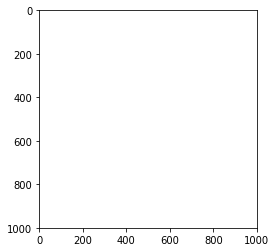

In [120]:
ani = make_animation(1860, curr_img,V,100)

In [121]:
from IPython.display import HTML
HTML(ani.to_jshtml())

### Experiment 3: real radar images + velocity gradient+low diffusion coefficient

Parameter description:
    
    D:1;
    dt=60;
    V: the same as experiment 2

1 689 -1 4 687 692
1 690 -1 4 688 693
1 691 -1 4 689 694
1 692 -1 4 690 695
1 693 -1 4 691 696
1 694 -1 4 692 697
1 695 -1 4 693 698
1 696 -1 4 694 699
1 697 -1 4 695 700
1 698 -1 4 696 701
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
1 693 -1 4 691 696
1 694 -1 4 692 697
1 695 -1 4 693 698
1 696 -1 4 694 699
1 697 -1 4 695 700
1 698 -1 4 696 701
1 699 -1 4 697 702
1 700 -1 4 698 703
1 701 -1 4 699 704
1 702 -1 4 700 705
1 703 -1 4 701 706
1 704 -1 4 702 707
1 705 -1 4 703 708
1 706 -1 4 704 709
1 708 -1 4 706 711
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
1 697 -1 4 695 700
1 698 -1 4 696 701
1 699 -1 4 697 702
1 700 -1 4 698 703
1 701 -1 4 699 704
1 702 -1 4 700 705
1 703 -1 4 701 706
1 704 -1 4 702 707
1 705 -1 4 703 708
1 706 -1 4 704 709
1 708 -1 4 706 711
1 709 -1 4 707 712
1 710 -1 4 708 713
1 711 -1 4 709 714
1 712 -1 4 710 715
1 713 -1 4 7

0 780 -2 3 778 783
0 781 -2 3 779 784
0 782 -2 3 780 785
0 783 -2 3 781 786
0 784 -2 3 782 787
0 785 -2 3 783 788
0 786 -2 3 784 789
0 787 -2 3 785 790
0 788 -2 3 786 791
0 789 -2 3 787 792
0 790 -2 3 788 793
0 791 -2 3 789 794
0 792 -2 3 790 795
0 793 -2 3 791 796
0 794 -2 3 792 797
0 796 -2 3 794 799
1 773 -1 4 771 776
1 774 -1 4 772 777
1 775 -1 4 773 778
1 776 -1 4 774 779
1 777 -1 4 775 780
1 778 -1 4 776 781
1 779 -1 4 777 782
1 780 -1 4 778 783
1 781 -1 4 779 784
1 782 -1 4 780 785
1 783 -1 4 781 786
1 784 -1 4 782 787
1 785 -1 4 783 788
1 786 -1 4 784 789
1 787 -1 4 785 790
1 788 -1 4 786 791
1 789 -1 4 787 792
1 790 -1 4 788 793
1 791 -1 4 789 794
1 792 -1 4 790 795
1 793 -1 4 791 796
1 794 -1 4 792 797
1 795 -1 4 793 798
1 796 -1 4 794 799
1 797 -1 4 795 800
1 798 -1 4 796 801
1 799 -1 4 797 802
1 800 -1 4 798 803
1 801 -1 4 799 804
0 788 -2 3 786 791
0 789 -2 3 787 792
0 790 -2 3 788 793
0 791 -2 3 789 794
0 792 -2 3 790 795
0 793 -2 3 791 796
0 794 -2 3 792 797
0 795 -2 3 7

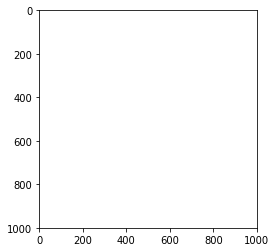

In [124]:
ani = make_animation(1860, curr_img,V,1)

In [125]:
from IPython.display import HTML
HTML(ani.to_jshtml())

Things starts to break down because the diffusion coefficient is fairly low

### Experiment 4: real radar images + velocity gradient+intermediate diffusion coefficient

1 641 -1 4 639 644
1 642 -1 4 640 645
1 643 -1 4 641 646
1 644 -1 4 642 647
1 645 -1 4 643 648
1 646 -1 4 644 649
1 647 -1 4 645 650
1 648 -1 4 646 651
1 649 -1 4 647 652
1 650 -1 4 648 653
1 651 -1 4 649 654
1 652 -1 4 650 655
1 653 -1 4 651 656
1 654 -1 4 652 657
1 655 -1 4 653 658
1 656 -1 4 654 659
1 657 -1 4 655 660
1 658 -1 4 656 661
1 659 -1 4 657 662
1 660 -1 4 658 663
1 661 -1 4 659 664
0 643 -2 3 641 646
0 644 -2 3 642 647
0 645 -2 3 643 648
0 646 -2 3 644 649
0 647 -2 3 645 650
0 648 -2 3 646 651
0 649 -2 3 647 652
0 650 -2 3 648 653
0 651 -2 3 649 654
0 652 -2 3 650 655
0 653 -2 3 651 656
0 654 -2 3 652 657
0 655 -2 3 653 658
0 656 -2 3 654 659
0 657 -2 3 655 660
0 658 -2 3 656 661
0 659 -2 3 657 662
0 660 -2 3 658 663
0 661 -2 3 659 664
0 662 -2 3 660 665
0 663 -2 3 661 666
0 664 -2 3 662 667
0 665 -2 3 663 668
0 666 -2 3 664 669
0 667 -2 3 665 670
0 668 -2 3 666 671
0 669 -2 3 667 672
0 670 -2 3 668 673
0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
1 639 -1 4 6

0 659 -2 3 657 662
0 660 -2 3 658 663
0 661 -2 3 659 664
0 662 -2 3 660 665
0 663 -2 3 661 666
0 664 -2 3 662 667
0 665 -2 3 663 668
0 666 -2 3 664 669
0 667 -2 3 665 670
0 668 -2 3 666 671
0 669 -2 3 667 672
0 670 -2 3 668 673
0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
0 674 -2 3 672 677
0 675 -2 3 673 678
0 676 -2 3 674 679
0 677 -2 3 675 680
0 678 -2 3 676 681
0 679 -2 3 677 682
0 680 -2 3 678 683
0 681 -2 3 679 684
0 682 -2 3 680 685
0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 7

0 671 -2 3 669 674
0 672 -2 3 670 675
0 673 -2 3 671 676
0 674 -2 3 672 677
0 675 -2 3 673 678
0 676 -2 3 674 679
0 677 -2 3 675 680
0 678 -2 3 676 681
0 679 -2 3 677 682
0 680 -2 3 678 683
0 681 -2 3 679 684
0 682 -2 3 680 685
0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 7

0 683 -2 3 681 686
0 684 -2 3 682 687
0 685 -2 3 683 688
0 686 -2 3 684 689
0 687 -2 3 685 690
0 688 -2 3 686 691
0 689 -2 3 687 692
0 690 -2 3 688 693
0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 722 727
0 725 -2 3 723 728
0 726 -2 3 724 729
0 727 -2 3 725 730
0 728 -2 3 726 731
0 729 -2 3 727 732
0 730 -2 3 728 733
0 731 -2 3 729 734
0 732 -2 3 730 735
0 733 -2 3 731 736
0 734 -2 3 732 737
0 735 -2 3 733 738
0 736 -2 3 7

0 691 -2 3 689 694
0 692 -2 3 690 695
0 693 -2 3 691 696
0 694 -2 3 692 697
0 695 -2 3 693 698
0 696 -2 3 694 699
0 697 -2 3 695 700
0 698 -2 3 696 701
0 699 -2 3 697 702
0 700 -2 3 698 703
0 701 -2 3 699 704
0 702 -2 3 700 705
0 703 -2 3 701 706
0 704 -2 3 702 707
0 705 -2 3 703 708
0 706 -2 3 704 709
0 708 -2 3 706 711
0 709 -2 3 707 712
0 710 -2 3 708 713
0 711 -2 3 709 714
0 712 -2 3 710 715
0 713 -2 3 711 716
0 714 -2 3 712 717
0 715 -2 3 713 718
0 716 -2 3 714 719
0 717 -2 3 715 720
0 718 -2 3 716 721
0 719 -2 3 717 722
0 720 -2 3 718 723
0 721 -2 3 719 724
0 722 -2 3 720 725
0 723 -2 3 721 726
0 724 -2 3 722 727
0 725 -2 3 723 728
0 726 -2 3 724 729
0 727 -2 3 725 730
0 728 -2 3 726 731
0 729 -2 3 727 732
0 730 -2 3 728 733
0 731 -2 3 729 734
0 732 -2 3 730 735
0 733 -2 3 731 736
0 734 -2 3 732 737
0 735 -2 3 733 738
0 736 -2 3 734 739
0 737 -2 3 735 740
0 738 -2 3 736 741
0 739 -2 3 737 742
0 740 -2 3 738 743
0 741 -2 3 739 744
0 742 -2 3 740 745
0 743 -2 3 741 746
0 744 -2 3 7

1 794 -1 4 792 797
1 795 -1 4 793 798
1 796 -1 4 794 799
1 797 -1 4 795 800
1 798 -1 4 796 801
1 799 -1 4 797 802
1 800 -1 4 798 803
1 801 -1 4 799 804
1 802 -1 4 800 805
1 803 -1 4 801 806
1 804 -1 4 802 807
1 805 -1 4 803 808
1 806 -1 4 804 809
1 807 -1 4 805 810
1 809 -1 4 807 812
1 810 -1 4 808 813
1 811 -1 4 809 814
1 812 -1 4 810 815
1 813 -1 4 811 816
1 814 -1 4 812 817
1 815 -1 4 813 818
1 816 -1 4 814 819
1 817 -1 4 815 820
1 818 -1 4 816 821
1 819 -1 4 817 822
1 820 -1 4 818 823
1 821 -1 4 819 824
1 822 -1 4 820 825
1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 833 838
1 836 -1 4 834 839
1 837 -1 4 835 840
1 838 -1 4 836 841
1 839 -1 4 837 842
1 840 -1 4 838 843
1 841 -1 4 839 844
1 842 -1 4 840 845
1 843 -1 4 841 846
1 844 -1 4 842 847
1 845 -1 4 843 848
1 846 -1 4 844 849
1 847 -1 4 8

1 790 -1 4 788 793
1 791 -1 4 789 794
1 792 -1 4 790 795
1 793 -1 4 791 796
1 794 -1 4 792 797
1 795 -1 4 793 798
1 796 -1 4 794 799
1 797 -1 4 795 800
1 798 -1 4 796 801
1 799 -1 4 797 802
1 800 -1 4 798 803
1 801 -1 4 799 804
1 802 -1 4 800 805
1 803 -1 4 801 806
1 804 -1 4 802 807
1 805 -1 4 803 808
1 806 -1 4 804 809
1 807 -1 4 805 810
1 809 -1 4 807 812
1 810 -1 4 808 813
1 811 -1 4 809 814
1 812 -1 4 810 815
1 813 -1 4 811 816
1 814 -1 4 812 817
1 815 -1 4 813 818
1 816 -1 4 814 819
1 817 -1 4 815 820
1 818 -1 4 816 821
1 819 -1 4 817 822
1 820 -1 4 818 823
1 821 -1 4 819 824
1 822 -1 4 820 825
1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 833 838
1 836 -1 4 834 839
1 837 -1 4 835 840
1 838 -1 4 836 841
1 839 -1 4 837 842
1 840 -1 4 838 843
1 841 -1 4 839 844
1 842 -1 4 840 845
1 843 -1 4 8

1 906 -1 4 904 909
1 907 -1 4 905 910
1 908 -1 4 906 911
0 199 -2 3 197 202
0 200 -2 3 198 203
0 202 -2 3 200 205
0 203 -2 3 201 206
0 204 -2 3 202 207
0 205 -2 3 203 208
0 206 -2 3 204 209
0 207 -2 3 205 210
0 208 -2 3 206 211
0 209 -2 3 207 212
0 210 -2 3 208 213
0 211 -2 3 209 214
0 212 -2 3 210 215
0 213 -2 3 211 216
0 214 -2 3 212 217
0 215 -2 3 213 218
0 216 -2 3 214 219
0 217 -2 3 215 220
0 218 -2 3 216 221
0 219 -2 3 217 222
0 220 -2 3 218 223
0 221 -2 3 219 224
0 222 -2 3 220 225
0 223 -2 3 221 226
0 224 -2 3 222 227
0 225 -2 3 223 228
0 226 -2 3 224 229
0 227 -2 3 225 230
0 228 -2 3 226 231
0 229 -2 3 227 232
0 230 -2 3 228 233
0 231 -2 3 229 234
0 232 -2 3 230 235
0 233 -2 3 231 236
0 234 -2 3 232 237
0 235 -2 3 233 238
0 236 -2 3 234 239
0 237 -2 3 235 240
0 238 -2 3 236 241
0 239 -2 3 237 242
0 240 -2 3 238 243
0 241 -2 3 239 244
0 242 -2 3 240 245
0 243 -2 3 241 246
0 244 -2 3 242 247
0 245 -2 3 243 248
0 246 -2 3 244 249
0 247 -2 3 245 250
0 248 -2 3 246 251
0 249 -2 3 2

1 782 -1 4 780 785
1 783 -1 4 781 786
1 784 -1 4 782 787
1 785 -1 4 783 788
1 786 -1 4 784 789
1 787 -1 4 785 790
1 788 -1 4 786 791
1 789 -1 4 787 792
1 790 -1 4 788 793
1 791 -1 4 789 794
1 792 -1 4 790 795
1 793 -1 4 791 796
1 794 -1 4 792 797
1 795 -1 4 793 798
1 796 -1 4 794 799
1 797 -1 4 795 800
1 798 -1 4 796 801
1 799 -1 4 797 802
1 800 -1 4 798 803
1 801 -1 4 799 804
1 802 -1 4 800 805
1 803 -1 4 801 806
1 804 -1 4 802 807
1 805 -1 4 803 808
1 806 -1 4 804 809
1 807 -1 4 805 810
1 809 -1 4 807 812
1 810 -1 4 808 813
1 811 -1 4 809 814
1 812 -1 4 810 815
1 813 -1 4 811 816
1 814 -1 4 812 817
1 815 -1 4 813 818
1 816 -1 4 814 819
1 817 -1 4 815 820
1 818 -1 4 816 821
1 819 -1 4 817 822
1 820 -1 4 818 823
1 821 -1 4 819 824
1 822 -1 4 820 825
1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 8

1 461 -1 4 459 464
1 462 -1 4 460 465
1 463 -1 4 461 466
1 464 -1 4 462 467
1 465 -1 4 463 468
1 466 -1 4 464 469
1 467 -1 4 465 470
1 468 -1 4 466 471
1 469 -1 4 467 472
1 470 -1 4 468 473
1 471 -1 4 469 474
1 472 -1 4 470 475
1 473 -1 4 471 476
1 474 -1 4 472 477
1 475 -1 4 473 478
1 476 -1 4 474 479
1 477 -1 4 475 480
1 478 -1 4 476 481
1 479 -1 4 477 482
1 480 -1 4 478 483
1 481 -1 4 479 484
1 482 -1 4 480 485
1 483 -1 4 481 486
1 484 -1 4 482 487
1 485 -1 4 483 488
1 486 -1 4 484 489
1 487 -1 4 485 490
1 488 -1 4 486 491
1 489 -1 4 487 492
1 490 -1 4 488 493
1 491 -1 4 489 494
1 492 -1 4 490 495
1 493 -1 4 491 496
1 494 -1 4 492 497
1 495 -1 4 493 498
1 496 -1 4 494 499
1 497 -1 4 495 500
1 498 -1 4 496 501
1 499 -1 4 497 502
1 500 -1 4 498 503
1 501 -1 4 499 504
1 502 -1 4 500 505
1 503 -1 4 501 506
1 506 -1 4 504 509
1 507 -1 4 505 510
1 508 -1 4 506 511
1 509 -1 4 507 512
1 510 -1 4 508 513
1 511 -1 4 509 514
1 512 -1 4 510 515
1 513 -1 4 511 516
1 514 -1 4 512 517
1 515 -1 4 5

0 735 -2 3 733 738
0 736 -2 3 734 739
0 737 -2 3 735 740
0 738 -2 3 736 741
0 739 -2 3 737 742
0 740 -2 3 738 743
0 741 -2 3 739 744
0 742 -2 3 740 745
0 743 -2 3 741 746
0 744 -2 3 742 747
0 745 -2 3 743 748
0 746 -2 3 744 749
0 747 -2 3 745 750
0 748 -2 3 746 751
0 749 -2 3 747 752
0 750 -2 3 748 753
0 751 -2 3 749 754
0 752 -2 3 750 755
0 753 -2 3 751 756
0 754 -2 3 752 757
0 755 -2 3 753 758
0 756 -2 3 754 759
0 757 -2 3 755 760
0 758 -2 3 756 761
0 759 -2 3 757 762
0 760 -2 3 758 763
0 761 -2 3 759 764
0 762 -2 3 760 765
0 763 -2 3 761 766
0 764 -2 3 762 767
0 765 -2 3 763 768
0 766 -2 3 764 769
0 767 -2 3 765 770
0 768 -2 3 766 771
0 769 -2 3 767 772
0 770 -2 3 768 773
0 771 -2 3 769 774
0 772 -2 3 770 775
0 773 -2 3 771 776
0 774 -2 3 772 777
0 775 -2 3 773 778
0 776 -2 3 774 779
0 777 -2 3 775 780
0 778 -2 3 776 781
0 779 -2 3 777 782
0 780 -2 3 778 783
0 781 -2 3 779 784
0 782 -2 3 780 785
0 783 -2 3 781 786
0 784 -2 3 782 787
0 785 -2 3 783 788
0 786 -2 3 784 789
0 787 -2 3 7

1 799 -1 4 797 802
1 800 -1 4 798 803
1 801 -1 4 799 804
1 802 -1 4 800 805
1 803 -1 4 801 806
1 804 -1 4 802 807
1 805 -1 4 803 808
1 806 -1 4 804 809
1 807 -1 4 805 810
1 809 -1 4 807 812
1 810 -1 4 808 813
1 811 -1 4 809 814
1 812 -1 4 810 815
1 813 -1 4 811 816
1 814 -1 4 812 817
1 815 -1 4 813 818
1 816 -1 4 814 819
1 817 -1 4 815 820
1 818 -1 4 816 821
1 819 -1 4 817 822
1 820 -1 4 818 823
1 821 -1 4 819 824
1 822 -1 4 820 825
1 823 -1 4 821 826
1 824 -1 4 822 827
1 825 -1 4 823 828
1 826 -1 4 824 829
1 827 -1 4 825 830
1 828 -1 4 826 831
1 829 -1 4 827 832
1 830 -1 4 828 833
1 831 -1 4 829 834
1 832 -1 4 830 835
1 833 -1 4 831 836
1 834 -1 4 832 837
1 835 -1 4 833 838
1 836 -1 4 834 839
1 837 -1 4 835 840
1 838 -1 4 836 841
1 839 -1 4 837 842
1 840 -1 4 838 843
1 841 -1 4 839 844
1 842 -1 4 840 845
1 843 -1 4 841 846
1 844 -1 4 842 847
1 845 -1 4 843 848
1 846 -1 4 844 849
1 847 -1 4 845 850
1 848 -1 4 846 851
1 849 -1 4 847 852
1 850 -1 4 848 853
1 851 -1 4 849 854
1 852 -1 4 8

1 312 -1 4 310 315
1 313 -1 4 311 316
1 314 -1 4 312 317
1 315 -1 4 313 318
1 316 -1 4 314 319
1 317 -1 4 315 320
1 318 -1 4 316 321
1 319 -1 4 317 322
1 320 -1 4 318 323
1 321 -1 4 319 324
1 322 -1 4 320 325
1 323 -1 4 321 326
1 324 -1 4 322 327
1 325 -1 4 323 328
1 326 -1 4 324 329
1 327 -1 4 325 330
1 328 -1 4 326 331
1 329 -1 4 327 332
1 330 -1 4 328 333
1 331 -1 4 329 334
1 332 -1 4 330 335
1 333 -1 4 331 336
1 334 -1 4 332 337
1 335 -1 4 333 338
1 336 -1 4 334 339
1 337 -1 4 335 340
1 338 -1 4 336 341
1 339 -1 4 337 342
1 443 -1 4 441 446
1 444 -1 4 442 447
1 445 -1 4 443 448
1 446 -1 4 444 449
1 447 -1 4 445 450
1 448 -1 4 446 451
1 449 -1 4 447 452
1 450 -1 4 448 453
1 451 -1 4 449 454
1 452 -1 4 450 455
1 453 -1 4 451 456
1 454 -1 4 452 457
1 455 -1 4 453 458
1 456 -1 4 454 459
1 457 -1 4 455 460
1 458 -1 4 456 461
1 459 -1 4 457 462
1 460 -1 4 458 463
1 461 -1 4 459 464
1 462 -1 4 460 465
1 463 -1 4 461 466
1 464 -1 4 462 467
1 465 -1 4 463 468
1 466 -1 4 464 469
1 467 -1 4 4

378 0 376 381 -2 3
378 1 376 381 -1 4
379 0 377 382 -2 3
379 1 377 382 -1 4
380 0 378 383 -2 3
380 1 378 383 -1 4
381 0 379 384 -2 3
381 1 379 384 -1 4
382 0 380 385 -2 3
382 1 380 385 -1 4
383 0 381 386 -2 3
383 1 381 386 -1 4
384 0 382 387 -2 3
384 1 382 387 -1 4
385 0 383 388 -2 3
385 1 383 388 -1 4
386 0 384 389 -2 3
386 1 384 389 -1 4
387 0 385 390 -2 3
387 1 385 390 -1 4
388 0 386 391 -2 3
388 1 386 391 -1 4
389 0 387 392 -2 3
389 1 387 392 -1 4
390 0 388 393 -2 3
390 1 388 393 -1 4
391 0 389 394 -2 3
391 1 389 394 -1 4
392 0 390 395 -2 3
392 1 390 395 -1 4
393 0 391 396 -2 3
393 1 391 396 -1 4
394 0 392 397 -2 3
394 1 392 397 -1 4
395 0 393 398 -2 3
395 1 393 398 -1 4
396 0 394 399 -2 3
396 1 394 399 -1 4
397 0 395 400 -2 3
397 1 395 400 -1 4
398 0 396 401 -2 3
398 1 396 401 -1 4
399 0 397 402 -2 3
399 1 397 402 -1 4
400 0 398 403 -2 3
400 1 398 403 -1 4
401 0 399 404 -2 3
401 1 399 404 -1 4
402 0 400 405 -2 3
402 1 400 405 -1 4
404 0 402 407 -2 3
404 1 402 407 -1 4
405 1 403 40

1 495 -1 4 493 498
1 496 -1 4 494 499
1 497 -1 4 495 500
1 498 -1 4 496 501
1 499 -1 4 497 502
1 500 -1 4 498 503
1 501 -1 4 499 504
1 502 -1 4 500 505
1 503 -1 4 501 506
1 506 -1 4 504 509
1 507 -1 4 505 510
1 508 -1 4 506 511
1 509 -1 4 507 512
1 510 -1 4 508 513
1 511 -1 4 509 514
1 512 -1 4 510 515
1 513 -1 4 511 516
1 514 -1 4 512 517
1 515 -1 4 513 518
1 516 -1 4 514 519
1 517 -1 4 515 520
1 518 -1 4 516 521
1 519 -1 4 517 522
1 520 -1 4 518 523
1 521 -1 4 519 524
1 522 -1 4 520 525
1 523 -1 4 521 526
1 524 -1 4 522 527
1 525 -1 4 523 528
1 526 -1 4 524 529
1 527 -1 4 525 530
1 528 -1 4 526 531
1 529 -1 4 527 532
1 530 -1 4 528 533
1 531 -1 4 529 534
1 532 -1 4 530 535
1 533 -1 4 531 536
1 534 -1 4 532 537
1 535 -1 4 533 538
1 536 -1 4 534 539
1 537 -1 4 535 540
1 538 -1 4 536 541
1 539 -1 4 537 542
1 540 -1 4 538 543
1 541 -1 4 539 544
1 542 -1 4 540 545
1 543 -1 4 541 546
1 544 -1 4 542 547
1 545 -1 4 543 548
1 546 -1 4 544 549
1 547 -1 4 545 550
1 548 -1 4 546 551
1 549 -1 4 5

405 0 403 408 -2 3
405 1 403 408 -1 4
406 0 404 409 -2 3
406 1 404 409 -1 4
407 0 405 410 -2 3
407 1 405 410 -1 4
408 0 406 411 -2 3
408 1 406 411 -1 4
409 0 407 412 -2 3
409 1 407 412 -1 4
410 0 408 413 -2 3
410 1 408 413 -1 4
411 0 409 414 -2 3
411 1 409 414 -1 4
412 0 410 415 -2 3
412 1 410 415 -1 4
413 0 411 416 -2 3
413 1 411 416 -1 4
414 0 412 417 -2 3
414 1 412 417 -1 4
415 0 413 418 -2 3
415 1 413 418 -1 4
416 1 414 419 -1 4


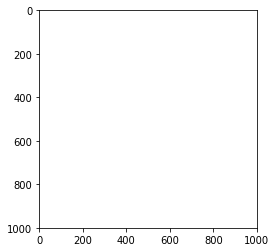

In [126]:
ani = make_animation(1860, curr_img,V,10)

In [127]:
from IPython.display import HTML
HTML(ani.to_jshtml())